In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import numpy
import torch
from time import time
from tqdm import tqdm

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
cwd = os.getcwd()
NOTEBOOK_DIR = os.path.dirname(cwd+'/')
ROOT = os.path.dirname(NOTEBOOK_DIR)

import sys
sys.path.append(ROOT)

In [4]:
from utils.tools import *

# Constants

In [5]:
INPUT_DIM = 50
BIAS = False

SEED = 42
N_TRAIN = 256
BATCH_SIZE = 64
ALPHA = 1e-1
BASE_LR = 1.0e-2
N_STEPS = int(5e3)
N_VAL = 100
VAL_ITER = 100
N_MAX_NEURONS = 2000

EPS = 1.0e-5
ETA = 0.0001
ALPHA = 0.0001
LAMBDA = 1.0

In [6]:
FIGURES_DIR = os.path.join(ROOT, 'figures/ista')
create_dir(FIGURES_DIR)

In [7]:
set_random_seeds(SEED)

# Data

In [8]:
def forward(a, b, x):
    if a.shape[1] == 0:
        return 0.
    return np.matmul(np.maximum(np.matmul(x, b.T), 0), a.T) / a.shape[1]

In [9]:
# Teacher Network
m_star = 50 # number of teacher neurons
eps = 3e-1

a_star = 2 * np.sign(np.random.uniform(size=(1, m_star)) - 0.5) # / m
b_star = 2 * np.random.uniform(size=(m_star, INPUT_DIM)) - 1 - eps * np.random.normal(size=(m_star, INPUT_DIM))**2

In [10]:
# Data
x_train = np.random.normal(size=(N_TRAIN, INPUT_DIM))
y_train = forward(a_star, b_star, x_train)

x_val = np.random.normal(size=(N_VAL, INPUT_DIM))
y_val = forward(a_star, b_star, x_val)

In [12]:
# particles for coordinate descent
m = 40
b = np.random.normal(size=(m, INPUT_DIM))
a = np.random.normal(size=(1, m))

# Algorithm iterations

In [11]:
def compute_losses(a, b, x, y, penalized=True):
    y_hat = forward(a, b, x)
    loss_ = 0.5 * np.mean((y_hat - y)**2)
    if penalized:
        penalized_loss = loss_ + LAMBDA * np.sum(np.abs(a))
    else:
        0.
    return loss_, penalized_loss

In [12]:
def train(n_steps, x_train, y_train, x_val, y_val, do_val=True):
    a = np.array([[]])
    b = np.array([[]])
    ms = [0]
    train_losses = []
    penalized_train_losses = []
    val_losses = []
    penalized_val_losses = []

    for k in tqdm(range(N_STEPS)):
        # sample and update iteration in 2 stpes
        a, b = add_new_neuron(a, b, x_train, y_train, eps=EPS)
        ms.append(a.shape[1])
        a, b = update_random_neuron(a, b, x_train, y_train, eps=EPS)
        ms.append(a.shape[1])
        
        # compute training loss
        train_loss, penalized_train_loss = compute_losses(a, b, x_train, y_train)
        train_losses.append(train_loss)
        penalized_train_losses.append(penalized_train_loss)
        
        # validation loop if do_val is True
        if do_val:
            if k % VAL_ITER == 0:
                val_loss, penalized_val_loss = compute_losses(a, b, x_val, y_val)
                val_losses.append(val_loss)
                penalized_val_losses.append(penalized_val_loss)
                print('m at step {:,} : {:,}'.format(k, ms[-1]))
                print('Train loss at step {:,} : {:.5f}'.format(k, train_loss))
                print('Validation loss at step {:,} : {:.5f}'.format(k, val_loss))
                
    return a, b, np.array(ms), np.array(train_losses), np.array(penalized_train_losses), np.array(val_losses), \
           np.array(penalized_val_losses) 

In [13]:
def add_new_neuron(a, b, x, y, eps=1.0e-6):
    new_b = np.random.normal(size=(1, INPUT_DIM))
    V = V_grad(a, b, x, y, new_b)
    new_a = ETA * soft_thresholding(V, tau=LAMBDA)
    # new_a = -ETA * soft_thresholding(V, tau=LAMBDA)
    
    if np.abs(new_a) > eps:
        if a.shape[1] == 0:
            a = np.array([[new_a]])
            b = new_b
        else:
            a = np.column_stack((a, [new_a]))
            b = np.row_stack((b, new_b))
    
    return a, b 

In [14]:
def update_random_neuron(a, b, x, y, eps=1.0e-6):
    if a.shape[1] > 0:
        j = np.random.randint(low=0, high=a.shape[1])
        b_j = b[j, :]
        V = V_grad(a, b, x, y, b_j) - a[0, j] / ALPHA 
        new_a = ALPHA * soft_thresholding(V, tau=LAMBDA)

        if np.abs(new_a) > eps:
            # update weight for neuron b_j
            a[0, j] = new_a  
        else:
            # remove a_j and b_j from the list
            a = np.column_stack((a[:, :j], a[:, j+1:]))
            b = np.row_stack((b[:j, :], b[j+1:, :]))
    return a, b  

$$\text{soft_thresholding}(V, \tau) = -\text{sign}(V) \times \max\Big(0,|V| - \tau \Big) $$

In [15]:
def soft_thresholding(V, tau):
    return - np.sign(V) * np.maximum(0, np.abs(V) - tau)

In [16]:
def V_grad(a, b, x, y, new_b):
    y_hat = forward(a, b, x)
    return np.mean((y_hat - y) * np.maximum(np.matmul(x, new_b.T), 0))

In [17]:
def forward_states(a, b, x):
    x_1 = np.maximum(np.matmul(x, b.T), 0)
    y_hat = np.matmul(x_1, a.T) / a.shape[1]
    return x_1, y_hat

In [18]:
a, b, ms, train_losses, penalized_train_losses, val_losses, penalized_val_losses = \
        train(N_STEPS, x_train, y_train, x_val, y_val)

  2%|▋                                       | 91/5000 [00:00<00:05, 906.74it/s]

m at step 0 : 1
Train loss at step 0 : 0.42803
Validation loss at step 0 : 0.37329
m at step 100 : 54
Train loss at step 100 : 0.42815
Validation loss at step 100 : 0.37338


  7%|██▋                                    | 345/5000 [00:00<00:06, 722.39it/s]

m at step 200 : 115
Train loss at step 200 : 0.42815
Validation loss at step 200 : 0.37339
m at step 300 : 171
Train loss at step 300 : 0.42816
Validation loss at step 300 : 0.37339


 10%|███▉                                   | 502/5000 [00:00<00:06, 736.79it/s]

m at step 400 : 222
Train loss at step 400 : 0.42816
Validation loss at step 400 : 0.37339
m at step 500 : 268
Train loss at step 500 : 0.42816
Validation loss at step 500 : 0.37339


 14%|█████▌                                 | 707/5000 [00:01<00:07, 565.49it/s]

m at step 600 : 328
Train loss at step 600 : 0.42816
Validation loss at step 600 : 0.37339
m at step 700 : 380
Train loss at step 700 : 0.42816
Validation loss at step 700 : 0.37339


 17%|██████▊                                | 868/5000 [00:01<00:08, 481.20it/s]

m at step 800 : 435
Train loss at step 800 : 0.42816
Validation loss at step 800 : 0.37339


 18%|███████▏                               | 917/5000 [00:01<00:09, 429.98it/s]

m at step 900 : 478
Train loss at step 900 : 0.42816
Validation loss at step 900 : 0.37339


 21%|███████▊                              | 1036/5000 [00:02<00:11, 344.84it/s]

m at step 1,000 : 531
Train loss at step 1,000 : 0.42816
Validation loss at step 1,000 : 0.37339


 23%|████████▌                             | 1134/5000 [00:02<00:15, 257.36it/s]

m at step 1,100 : 597
Train loss at step 1,100 : 0.42816
Validation loss at step 1,100 : 0.37339


 25%|█████████▍                            | 1244/5000 [00:02<00:14, 264.13it/s]

m at step 1,200 : 649
Train loss at step 1,200 : 0.42816
Validation loss at step 1,200 : 0.37340


 27%|██████████▎                           | 1349/5000 [00:03<00:14, 248.19it/s]

m at step 1,300 : 712
Train loss at step 1,300 : 0.42816
Validation loss at step 1,300 : 0.37339


 28%|██████████▊                           | 1423/5000 [00:03<00:16, 216.50it/s]

m at step 1,400 : 764
Train loss at step 1,400 : 0.42816
Validation loss at step 1,400 : 0.37339


 31%|███████████▌                          | 1529/5000 [00:04<00:19, 180.50it/s]

m at step 1,500 : 812
Train loss at step 1,500 : 0.42816
Validation loss at step 1,500 : 0.37339


 32%|████████████▎                         | 1622/5000 [00:04<00:19, 176.03it/s]

m at step 1,600 : 874
Train loss at step 1,600 : 0.42816
Validation loss at step 1,600 : 0.37339


 35%|█████████████▏                        | 1734/5000 [00:05<00:18, 178.81it/s]

m at step 1,700 : 931
Train loss at step 1,700 : 0.42816
Validation loss at step 1,700 : 0.37339


 36%|█████████████▊                        | 1824/5000 [00:06<00:19, 165.04it/s]

m at step 1,800 : 983
Train loss at step 1,800 : 0.42816
Validation loss at step 1,800 : 0.37339


 38%|██████████████▌                       | 1922/5000 [00:06<00:20, 151.85it/s]

m at step 1,900 : 1,027
Train loss at step 1,900 : 0.42816
Validation loss at step 1,900 : 0.37339


 40%|███████████████▎                      | 2018/5000 [00:07<00:19, 152.01it/s]

m at step 2,000 : 1,089
Train loss at step 2,000 : 0.42816
Validation loss at step 2,000 : 0.37339


 42%|████████████████                      | 2113/5000 [00:08<00:26, 108.64it/s]

m at step 2,100 : 1,143
Train loss at step 2,100 : 0.42816
Validation loss at step 2,100 : 0.37339


 44%|████████████████▉                     | 2221/5000 [00:09<00:21, 132.04it/s]

m at step 2,200 : 1,206
Train loss at step 2,200 : 0.42816
Validation loss at step 2,200 : 0.37339


 46%|█████████████████▌                    | 2318/5000 [00:09<00:22, 121.86it/s]

m at step 2,300 : 1,258
Train loss at step 2,300 : 0.42816
Validation loss at step 2,300 : 0.37339


 48%|██████████████████▍                   | 2418/5000 [00:10<00:22, 116.95it/s]

m at step 2,400 : 1,319
Train loss at step 2,400 : 0.42816
Validation loss at step 2,400 : 0.37339


 50%|███████████████████                   | 2516/5000 [00:11<00:23, 107.38it/s]

m at step 2,500 : 1,381
Train loss at step 2,500 : 0.42816
Validation loss at step 2,500 : 0.37339


 52%|███████████████████▉                  | 2620/5000 [00:12<00:22, 104.58it/s]

m at step 2,600 : 1,436
Train loss at step 2,600 : 0.42816
Validation loss at step 2,600 : 0.37339


 54%|████████████████████▋                 | 2714/5000 [00:13<00:20, 109.13it/s]

m at step 2,700 : 1,489
Train loss at step 2,700 : 0.42816
Validation loss at step 2,700 : 0.37339


 56%|█████████████████████▍                | 2822/5000 [00:14<00:21, 100.07it/s]

m at step 2,800 : 1,542
Train loss at step 2,800 : 0.42816
Validation loss at step 2,800 : 0.37339


 58%|██████████████████████▋                | 2912/5000 [00:15<00:22, 94.81it/s]

m at step 2,900 : 1,593
Train loss at step 2,900 : 0.42816
Validation loss at step 2,900 : 0.37339


 60%|███████████████████████▍               | 3012/5000 [00:16<00:21, 90.98it/s]

m at step 3,000 : 1,645
Train loss at step 3,000 : 0.42816
Validation loss at step 3,000 : 0.37339


 62%|████████████████████████▎              | 3115/5000 [00:17<00:21, 85.84it/s]

m at step 3,100 : 1,702
Train loss at step 3,100 : 0.42816
Validation loss at step 3,100 : 0.37339


 64%|█████████████████████████              | 3213/5000 [00:19<00:18, 94.15it/s]

m at step 3,200 : 1,757
Train loss at step 3,200 : 0.42816
Validation loss at step 3,200 : 0.37339


 66%|█████████████████████████▊             | 3311/5000 [00:20<00:19, 84.84it/s]

m at step 3,300 : 1,810
Train loss at step 3,300 : 0.42816
Validation loss at step 3,300 : 0.37339


 68%|██████████████████████████▌            | 3413/5000 [00:21<00:17, 88.73it/s]

m at step 3,400 : 1,866
Train loss at step 3,400 : 0.42816
Validation loss at step 3,400 : 0.37339


 70%|███████████████████████████▍           | 3510/5000 [00:22<00:19, 76.27it/s]

m at step 3,500 : 1,923
Train loss at step 3,500 : 0.42816
Validation loss at step 3,500 : 0.37339


 72%|████████████████████████████▏          | 3611/5000 [00:23<00:17, 77.53it/s]

m at step 3,600 : 1,972
Train loss at step 3,600 : 0.42816
Validation loss at step 3,600 : 0.37339


 74%|████████████████████████████▉          | 3715/5000 [00:25<00:15, 81.74it/s]

m at step 3,700 : 2,023
Train loss at step 3,700 : 0.42816
Validation loss at step 3,700 : 0.37339


 76%|█████████████████████████████▋         | 3809/5000 [00:26<00:17, 68.80it/s]

m at step 3,800 : 2,081
Train loss at step 3,800 : 0.42816
Validation loss at step 3,800 : 0.37339


 78%|██████████████████████████████▍        | 3908/5000 [00:27<00:17, 62.77it/s]

m at step 3,900 : 2,140
Train loss at step 3,900 : 0.42816
Validation loss at step 3,900 : 0.37339


 80%|███████████████████████████████▎       | 4012/5000 [00:29<00:12, 76.86it/s]

m at step 4,000 : 2,191
Train loss at step 4,000 : 0.42816
Validation loss at step 4,000 : 0.37339


 82%|████████████████████████████████       | 4114/5000 [00:30<00:13, 67.67it/s]

m at step 4,100 : 2,250
Train loss at step 4,100 : 0.42816
Validation loss at step 4,100 : 0.37339


 84%|████████████████████████████████▊      | 4208/5000 [00:32<00:11, 68.26it/s]

m at step 4,200 : 2,304
Train loss at step 4,200 : 0.42816
Validation loss at step 4,200 : 0.37339


 86%|█████████████████████████████████▌     | 4309/5000 [00:33<00:09, 72.92it/s]

m at step 4,300 : 2,355
Train loss at step 4,300 : 0.42816
Validation loss at step 4,300 : 0.37339


 88%|██████████████████████████████████▍    | 4410/5000 [00:35<00:08, 69.75it/s]

m at step 4,400 : 2,412
Train loss at step 4,400 : 0.42816
Validation loss at step 4,400 : 0.37339


 90%|███████████████████████████████████▏   | 4512/5000 [00:36<00:07, 68.82it/s]

m at step 4,500 : 2,475
Train loss at step 4,500 : 0.42816
Validation loss at step 4,500 : 0.37339


 92%|███████████████████████████████████▉   | 4613/5000 [00:38<00:05, 65.86it/s]

m at step 4,600 : 2,531
Train loss at step 4,600 : 0.42816
Validation loss at step 4,600 : 0.37339


 94%|████████████████████████████████████▊  | 4714/5000 [00:39<00:04, 68.56it/s]

m at step 4,700 : 2,581
Train loss at step 4,700 : 0.42816
Validation loss at step 4,700 : 0.37339


 96%|█████████████████████████████████████▌ | 4812/5000 [00:41<00:02, 63.35it/s]

m at step 4,800 : 2,637
Train loss at step 4,800 : 0.42816
Validation loss at step 4,800 : 0.37339


 98%|██████████████████████████████████████▎| 4910/5000 [00:42<00:01, 62.94it/s]

m at step 4,900 : 2,701
Train loss at step 4,900 : 0.42816
Validation loss at step 4,900 : 0.37339


100%|██████████████████████████████████████| 5000/5000 [00:44<00:00, 113.20it/s]


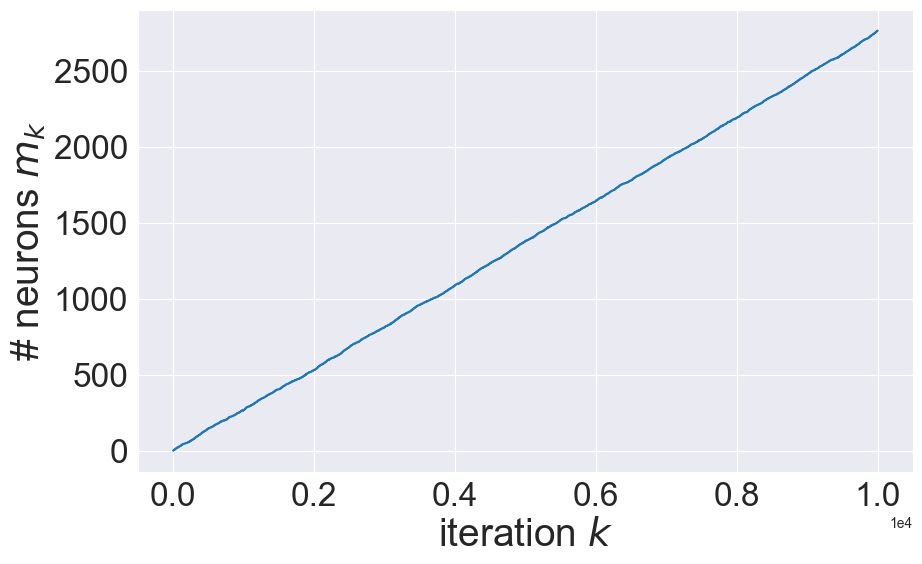

In [19]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(2*N_STEPS+1), ms)

plt.xlabel('iteration $k$', fontsize=28)
plt.ylabel('# neurons $m_k$', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.savefig(os.path.join(FIGURES_DIR, 'complexity-ista-1-1.png'), bbox_inches='tight')
plt.show()

In [22]:
ms[:20]

array([0, 1, 1, 2, 2, 3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 6, 6, 7, 7, 8])

In [23]:
len(ms)

10001

In [24]:
ms[100:140]

array([31, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 34, 34, 35, 35, 36, 36,
       37, 37, 37, 37, 38, 38, 39, 39, 40, 40, 41, 41, 41, 41, 41, 41, 42,
       42, 43, 43, 43, 43, 43])

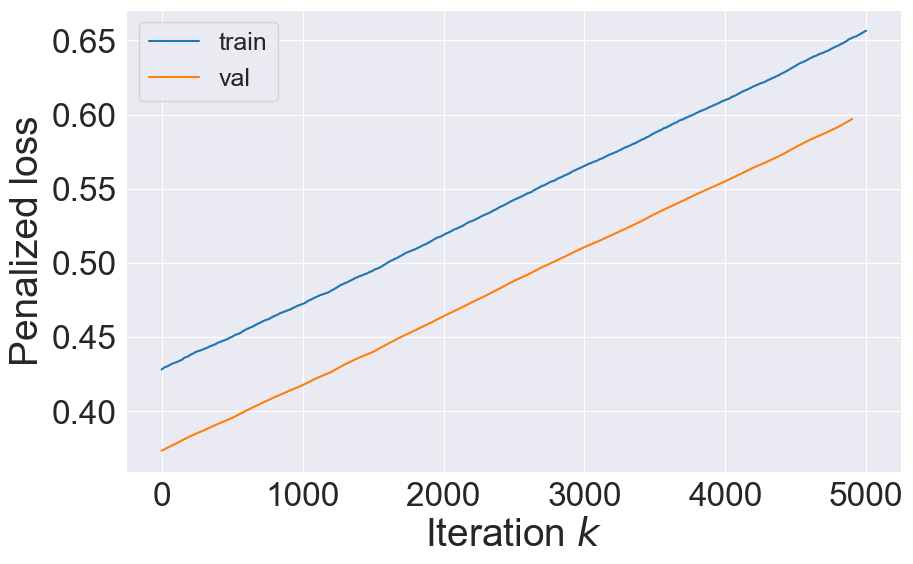

In [20]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(penalized_train_losses)), penalized_train_losses, label='train')
plt.plot([min(VAL_ITER * k, len(penalized_train_losses)) for k in range(len(penalized_val_losses))], 
         penalized_val_losses, label='val', marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Penalized loss', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

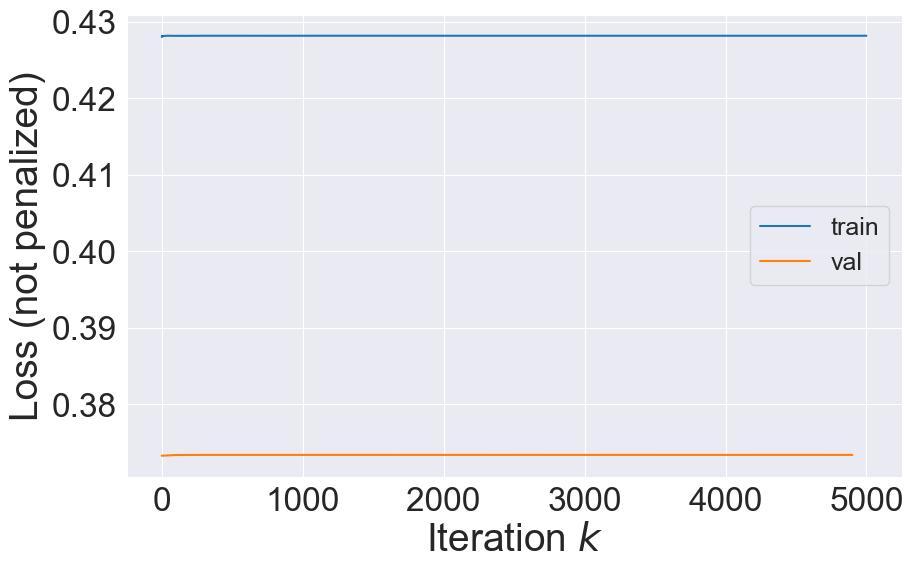

In [21]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(train_losses)), train_losses, label='train')
plt.plot([min(VAL_ITER * k, len(train_losses)) for k in range(len(val_losses))], val_losses, label='val', 
         marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Loss (not penalized)', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()